In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Beta
import torch.distributions as dist
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import os
import random
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import utils
import evaluate

In [2]:
def save_checkpoint(model, checkpoint_filename: str):
    dirname = os.path.dirname(checkpoint_filename) or "."
    os.makedirs(dirname, exist_ok=True)
    torch.save({"model_state": model.state_dict()}, checkpoint_filename+".pt")
    print(f"\n*** Saved checkpoint {checkpoint_filename}")

In [3]:
def plot_tensors_as_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))  # Create 1x5 grid of subplots
    for i in range(5):
        axs[i].imshow(images[i].cpu().detach().numpy(), cmap='Grays')  # Convert tensor to numpy for plotting
        axs[i].axis('off')  # Hide axes
    
    plt.show()

In [4]:
def get_device():
    if torch.cuda.is_available(): 
     dev = "cuda:0" 
    else: 
     dev = "cpu" 
    return torch.device(dev) 

In [5]:
device = get_device()
print(device)

cpu


In [7]:
class AutoDecoder(nn.Module):
    def __init__(self, x_dim, z_dim, latent_vectors, device=torch.device("cpu")):
        super().__init__()
        self.device = device
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.latent_vectors=nn.parameter.Parameter(latent_vectors, True)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        self.mlp = nn.Linear(x_dim,x_dim,bias=True)
        
    
    def decode(self, z):
        z = z.view(-1, self.z_dim, 1, 1)
        reconstructed_images = 255 * self.decoder(z).view(-1,28*28) # Output in range [0, 255]
        reconstructed_images = self.mlp(reconstructed_images)
        reconstructed_images = reconstructed_images.view(z.shape[0], 28, 28)
        return reconstructed_images
    
    def forward(self, z):
        z = z.view(-1, self.z_dim, 1, 1)
        reconstructed_images = 255 * self.decoder(z).view(-1,28*28) # Output in range [0, 255]
        reconstructed_images = self.mlp(reconstructed_images)
        reconstructed_images = reconstructed_images.view(z.shape[0], 28, 28)
        return reconstructed_images 

In [8]:
BATCH_SIZE = 64
LEARNING_RATE = 1e-2
NUM_EPOCHS = 750 
X_DIM = 28 * 28  
Z_DIM = 100
DISTR = "normal"

config = {
    "BATCH_SIZE": BATCH_SIZE,
    "LEARNING_RATE": LEARNING_RATE,
    "NUM_EPOCHS": NUM_EPOCHS,
    "X_DIM": X_DIM,
    "Z_DIM": Z_DIM,
    "DISTR": DISTR
}

In [9]:
train_ds, train_dl, test_ds, test_dl = utils.create_dataloaders("dataset", device, BATCH_SIZE)

In [10]:
latent_vectors = torch.randn(len(train_ds), Z_DIM, requires_grad=True, device = device)

In [11]:
ad = AutoDecoder(x_dim=X_DIM, 
                 z_dim=Z_DIM, 
                 latent_vectors = latent_vectors, 
                 device=device).to(device)
print(ad)

AutoDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
  (mlp): Linear(in_features=784, out_features=784, bias=True)
)


In [12]:
optim = torch.optim.Adam(params=ad.parameters(), lr=LEARNING_RATE)

In [13]:
# load
filename = f"./models/AD/AD_train2"
path = "./"+filename+".pt"

if(os.path.isfile(path)):
    state = torch.load(path)["model_state"]
    vad.load_state_dict(state)
    print("loaded checkpoint from", filename)
else:   
    train_losses = []
    
    print("TRAINING with ", config)
    for epoch in range(NUM_EPOCHS):
        batch_losses = []
        
        for batch_i, batch in enumerate(train_dl):
            idx, x = batch
                
            x_reconstruction = ad.forward(ad.latent_vectors[idx])
            loss = evaluate.reconstruction_loss(x_reconstruction, x.float())
            
            optim.zero_grad()
            loss.backward()    
            optim.step()
            
            batch_losses.append(loss.data.cpu().item())
        
        train_losses.append(np.mean(batch_losses))
    
        if(epoch % 50 == 0):
            print("epoch: {} training loss: {:.5f}".format(epoch, train_losses[-1]))
    
    save_checkpoint(ad,filename)

TRAINING with  {'BATCH_SIZE': 64, 'LEARNING_RATE': 0.01, 'NUM_EPOCHS': 750, 'X_DIM': 784, 'Z_DIM': 100, 'DISTR': 'normal'}
epoch: 0 training loss: 0.75072
epoch: 50 training loss: 0.13603
epoch: 100 training loss: 0.07599
epoch: 150 training loss: 0.05373
epoch: 200 training loss: 0.04530
epoch: 250 training loss: 0.03391
epoch: 300 training loss: 0.03721
epoch: 350 training loss: 0.02820
epoch: 400 training loss: 0.02723
epoch: 450 training loss: 0.02498
epoch: 500 training loss: 0.02254
epoch: 550 training loss: 0.02154
epoch: 600 training loss: 0.02251
epoch: 650 training loss: 0.02013
epoch: 700 training loss: 0.02125

*** Saved checkpoint ./models/AD/AD_train2


In [14]:
#utils.plot_tsne(train_ds, ad.latent_vectors, f"./TSNE/AD_TSNE_{DISTR}")

In [15]:
#EVALUATING ON TRAIN
latent_vectors = torch.randn(len(train_ds), Z_DIM, requires_grad=True, device = device)

ad.latent_vectors = torch.nn.Parameter(latent_vectors,True)

opt = torch.optim.Adam([ad.latent_vectors], lr=LEARNING_RATE)

train_res = evaluate.evaluate_model(ad, train_dl, opt, ad.latent_vectors, 500 , device)
print("TRAIN EVALUATION LOSS: ", train_res)

utils.plot_tsne(train_ds, ad.latent_vectors, "AD_TSNE_train")

.
.
.
.
.
.
.
.
.
.
TRAIN EVALUATION LOSS:  0.025210941152181476


<Figure size 800x600 with 0 Axes>

In [16]:
#EVALUATING ON TEST
latent_vectors = torch.randn(len(test_ds), Z_DIM, requires_grad=True, device = device)

ad.latent_vectors = torch.nn.Parameter(latent_vectors,True)

opt = torch.optim.Adam([ad.latent_vectors], lr=LEARNING_RATE)

train_res = evaluate.evaluate_model(ad, test_dl, opt, ad.latent_vectors, 500, device)
print("TEST EVALUATION LOSS: ", train_res)

utils.plot_tsne(train_ds, ad.latent_vectors, "AD_TSNE_test")

.
.
.
.
.
.
.
.
.
.
TEST EVALUATION LOSS:  0.11863428447395563


<Figure size 800x600 with 0 Axes>

tensor(71.7321, grad_fn=<MeanBackward0>)


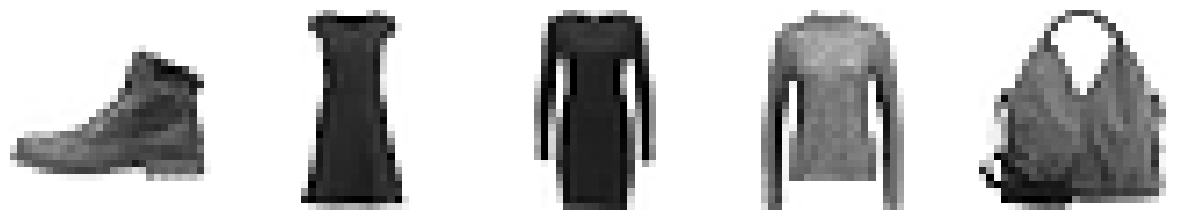

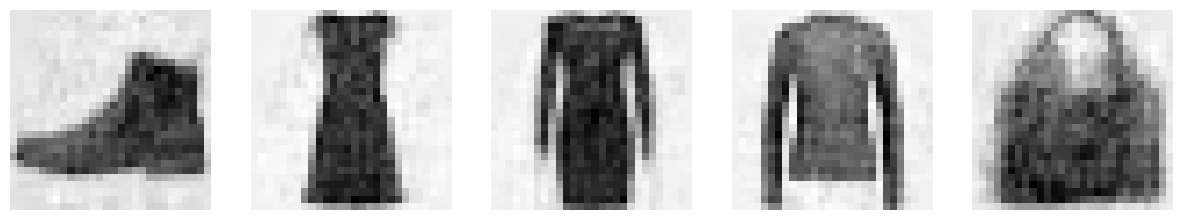

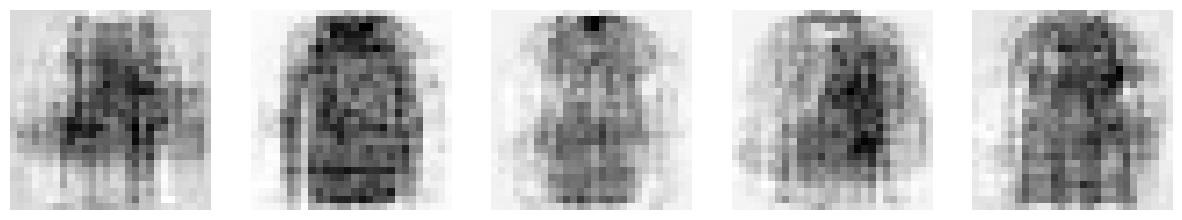

In [18]:
num_samples = 5

random_indices = random.sample(range(100), num_samples)
initial = test_ds[random_indices][1]

latent_vectors = ad.latent_vectors[random_indices]
restored_test = ad(latent_vectors).view(-1, 28, 28)

random_latent_vectors = torch.randn(num_samples, Z_DIM, requires_grad=True, device = device)
restored_random = ad(random_latent_vectors).view(-1, 28, 28)
print(restored_random.mean())
plot_tensors_as_images(initial)
plot_tensors_as_images(restored_test)
plot_tensors_as_images(restored_random)